In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import seaborn as sns

data = pd.read_csv('minnesota.csv', usecols=['brokered_by', 'bed', 'bath', 'acre_lot', 'street', 'city', 'house_size', 'price'])

categorical_features = ['brokered_by', 'street', 'city']
numerical_features = ['bed', 'bath', 'acre_lot']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_split, X_validation, y_train_split, y_validation = train_test_split(
    X_train, y_train, test_size=0.125, random_state=0)  # 0.125 x 0.8 = 0.1 of total data

target_scaler = StandardScaler()

y_train_split_scaled = target_scaler.fit_transform(y_train_split.values.reshape(-1, 1)).ravel()
y_validation_scaled = target_scaler.transform(y_validation.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

#### You might be wondering why I am scaling the y data. The problem with our data is that there are 27000 data points. Among those data points, too many of them are outliers, hence there are too many random points, which affects the score heavily. When I tried gridsearchcv with 500 iterations, my test score was as low as -1.63, which indicates there is something wrong with the data.
####                                            mean_train_score|mean_test_score  
#### 0                            (5,)         -1.414401        -1.436211   
#### 1                          (5, 5)          0.364607        -1.635144   
#### 2                       (5, 5, 5)          0.800949        -1.187202   
#### 3                    (5, 5, 5, 5)          0.140255        -0.307092  
#### For the final evaluation, I am going to descale the target "price" back

In [58]:
hidden_layer = [
    (25,),
    (25, 25),
    (25, 25, 25),
    (25, 25, 25, 25)
]

results = []

kf = KFold(n_splits=3, shuffle=True, random_state=0)

for layer in hidden_layer:
    train_scores = []
    val_scores = []
    
    print(f"hidden_layer_sizes: {layer}")
    
    for train_index, val_index in kf.split(X_train_split):
        X_train_cv, X_val_cv = X_train_split.iloc[train_index], X_train_split.iloc[val_index]
        y_train_cv, y_val_cv = y_train_split_scaled[train_index], y_train_split_scaled[val_index]
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', MLPRegressor(
                hidden_layer_sizes=layer,
                max_iter=2000,
                early_stopping=True,
                n_iter_no_change=20,
                random_state=0
            ))
        ])
        
        pipeline.fit(X_train_cv, y_train_cv)
        
        y_train_pred = pipeline.predict(X_train_cv)
        y_val_pred = pipeline.predict(X_val_cv)
        
        train_r2 = r2_score(y_train_cv, y_train_pred)
        val_r2 = r2_score(y_val_cv, y_val_pred)
        
        train_scores.append(train_r2)
        val_scores.append(val_r2)
    
    mean_train = np.mean(train_scores)
    mean_val = np.mean(val_scores)
    
    results.append({
        'hidden_layer_sizes': layer,
        'mean_train_r2': mean_train,
        'mean_val_r2': mean_val,
    })
    
    print(f"Mean Train R2: {mean_train:.4f}")
    print(f"Mean Validation R2: {mean_val:.4f}\n")

results_display = pd.DataFrame(results)

print(results_display)

best_row = results_display.loc[results_display['mean_val_r2'].idxmax()]
best_hidden_layers = best_row['hidden_layer_sizes']
print(f"\nTask 1: Best number of hidden layers: {len(best_hidden_layers)}")

hidden_layer_sizes: (25,)
Mean Train R2: 0.6993
Mean Validation R2: 0.1367

hidden_layer_sizes: (25, 25)
Mean Train R2: 0.6269
Mean Validation R2: 0.3452

hidden_layer_sizes: (25, 25, 25)
Mean Train R2: 0.8414
Mean Validation R2: 0.5780

hidden_layer_sizes: (25, 25, 25, 25)
Mean Train R2: 0.8008
Mean Validation R2: 0.3699

  hidden_layer_sizes  mean_train_r2  mean_val_r2
0              (25,)       0.699313     0.136727
1           (25, 25)       0.626871     0.345247
2       (25, 25, 25)       0.841395     0.578022
3   (25, 25, 25, 25)       0.800762     0.369903

Task 1: Best number of hidden layers: 3


#### Before this attempt with k-fold cv, I used gridsearch with 500, 1000 and 2000 iterations and cv = 5, cv = 3. The problem with this approach is that compilation time was unbearably long ranging from 15 minutes to 50+ to unknown amounts of time. 
#### In this approach, I only use 25 neurons in every layer, and only 4 layers. According to the results, 3 hidden layers displays the best result

In [59]:
num_layers = len(best_hidden_layers)

neurons_range = list(range(10, 50, 10))

hidden_layers_new = [tuple([n]*num_layers) for n in neurons_range]

results_new = []

for layer in hidden_layers_new:
    train_scores = []
    val_scores = []
    
    print(f"Evaluating hidden_layer_sizes: {layer}")
    
    for train_index, val_index in kf.split(X_train_split):
        X_train_cv, X_val_cv = X_train_split.iloc[train_index], X_train_split.iloc[val_index]
        y_train_cv, y_val_cv = y_train_split_scaled[train_index], y_train_split_scaled[val_index]
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', MLPRegressor(
                hidden_layer_sizes=layer,
                max_iter=2000,
                early_stopping=True,
                n_iter_no_change=20,
                random_state=0
            ))
        ])
        
        pipeline.fit(X_train_cv, y_train_cv)
        
        y_train_pred = pipeline.predict(X_train_cv)
        y_val_pred = pipeline.predict(X_val_cv)
        
        train_r2 = r2_score(y_train_cv, y_train_pred)
        val_r2 = r2_score(y_val_cv, y_val_pred)
        
        train_scores.append(train_r2)
        val_scores.append(val_r2)
    
    mean_train = np.mean(train_scores)
    mean_val = np.mean(val_scores)
    
    results_new.append({
        'hidden_layer_sizes': layer,
        'mean_train_r2': mean_train,
        'mean_val_r2': mean_val,
    })
    
    print(f"Mean Train R2: {mean_train:.4f}")
    print(f"Mean Validation R2: {mean_val:.4f}\n")

results_new = pd.DataFrame(results_new)

print(results_new)

best_row = results_new.loc[results_new['mean_val_r2'].idxmax()]
best_hidden_layers_sizes = best_row['hidden_layer_sizes']
print(f"\nTask 2: Best number of hidden layers: {best_hidden_layers_sizes}")

Evaluating hidden_layer_sizes: (10, 10, 10)
Mean Train R2: 0.8388
Mean Validation R2: 0.5053

Evaluating hidden_layer_sizes: (20, 20, 20)
Mean Train R2: 0.8126
Mean Validation R2: 0.5565

Evaluating hidden_layer_sizes: (30, 30, 30)
Mean Train R2: 0.8242
Mean Validation R2: -0.1575

Evaluating hidden_layer_sizes: (40, 40, 40)
Mean Train R2: 0.9583
Mean Validation R2: 0.5842

  hidden_layer_sizes  mean_train_r2  mean_val_r2
0       (10, 10, 10)       0.838795     0.505349
1       (20, 20, 20)       0.812616     0.556482
2       (30, 30, 30)       0.824176    -0.157475
3       (40, 40, 40)       0.958265     0.584177

Task 2: Best number of hidden layers: (40, 40, 40)


#### Using the results of task 1, I only used 3 hidden layers for task 2
#### As we can see, the more neurons I use, the better the mean score is. However, this assumption goes completely wrong when I use 30 neurons for every layer. (only comparing the validation scores)
#### Looking at the train score, for 40 neuron hidden layers, it goes too high. Hence, there is obviously overfitting. The best number of neurons seems to be 20 for every layer, despite what was computed

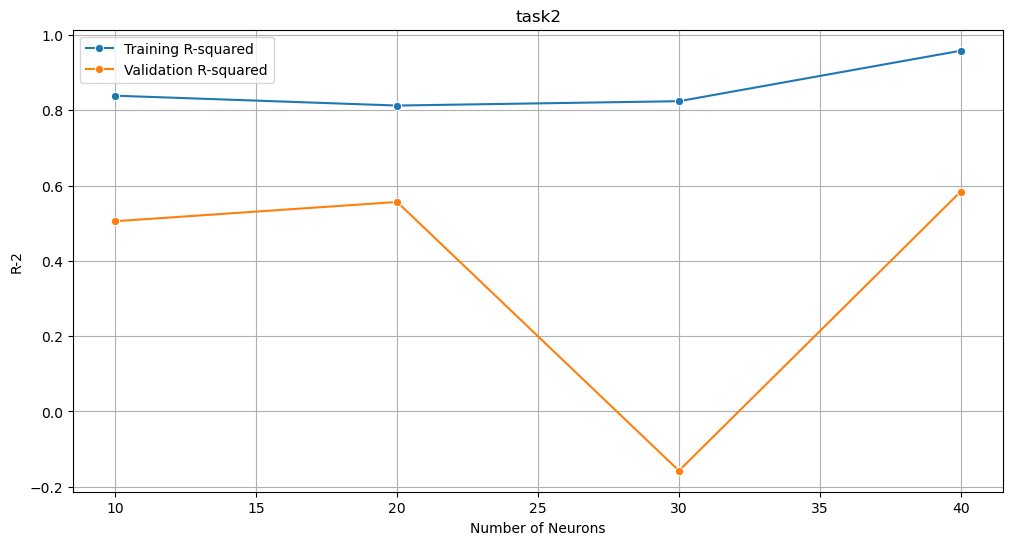

In [60]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=neurons_range,
    y=results_new['mean_train_r2'],
    marker='o',
    label='Training R-squared'
)
sns.lineplot(
    x=neurons_range,
    y=results_new['mean_val_r2'],
    marker='o',
    label='Validation R-squared'
)
plt.xlabel('Number of Neurons')
plt.ylabel('R-2')
plt.title('task2')
plt.legend()
plt.grid(True)
plt.show()

#### as you can see, the overfitting is displayed on the graph after 30 neurons

In [3]:
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MLPRegressor(
        hidden_layer_sizes=(20, 20, 20),
        max_iter=2000,
        early_stopping=True,
        n_iter_no_change=20,
        random_state=0
    ))
])

final_pipeline.fit(X_train, y_train_scaled)

y_pred_scaled_final = final_pipeline.predict(X_test)
y_pred_final = target_scaler.inverse_transform(y_pred_scaled_final.reshape(-1, 1)).ravel()

y_test_original = y_test.values

test_r2_final = r2_score(y_test_original, y_pred_final)
test_mse_final = mean_squared_error(y_test_original, y_pred_final)
test_mae_final = mean_absolute_error(y_test_original, y_pred_final)
print(f"\nFinal R2: {test_r2_final:.4f}")
print(f"MSE: {test_mse_final:.4f}")
print(f"MAE: {test_mae_final:.4f}")


Final R2: 0.6375
MSE: 34950124179.1334
MAE: 95102.5710


In [5]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor(strategy="mean")

dummy_reg.fit(X_train, y_train_scaled)

y_dummy_train_pred = dummy_reg.predict(X_train)
y_dummy_validation_pred = dummy_reg.predict(X_validation)
y_dummy_test_pred = dummy_reg.predict(X_test)

r2_dummy_train = r2_score(y_train, y_dummy_train_pred)
r2_dummy_validation = r2_score(y_validation, y_dummy_validation_pred)
r2_dummy_test = r2_score(y_test, y_dummy_test_pred)

mse_dummy_train = mean_squared_error(y_train, y_dummy_train_pred)
mse_dummy_validation = mean_squared_error(y_validation, y_dummy_validation_pred)
mse_dummy_test = mean_squared_error(y_test, y_dummy_test_pred)

mae_dummy_train = mean_absolute_error(y_train, y_dummy_train_pred)
mae_dummy_validation = mean_absolute_error(y_validation, y_dummy_validation_pred)
mae_dummy_test = mean_absolute_error(y_test, y_dummy_test_pred)

print("\nBaseline (Dummy Regressor predicting mean) Results:")
print(f"R-squared (Training set): {r2_dummy_train}")
print(f"R-squared (Validation set): {r2_dummy_validation}")
print(f"R-squared (Test set): {r2_dummy_test}")

print(f"MSE (Training set): {mse_dummy_train}")
print(f"MSE (Validation set): {mse_dummy_validation}")
print(f"MSE (Test set): {mse_dummy_test}")

print(f"MAE (Training set): {mae_dummy_train}")
print(f"MAE (Validation set): {mae_dummy_validation}")
print(f"MAE (Test set): {mae_dummy_test}")


Baseline (Dummy Regressor predicting mean) Results:
R-squared (Training set): -1.506276335761378
R-squared (Validation set): -1.5149252410563716
R-squared (Test set): -1.529924702813549
MSE (Training set): 244228523960.98126
MSE (Validation set): 247809728493.23767
MSE (Test set): 243887466274.3384
MAE (Training set): 383121.0746302513
MAE (Validation set): 386360.070754717
MAE (Test set): 384039.56722917804


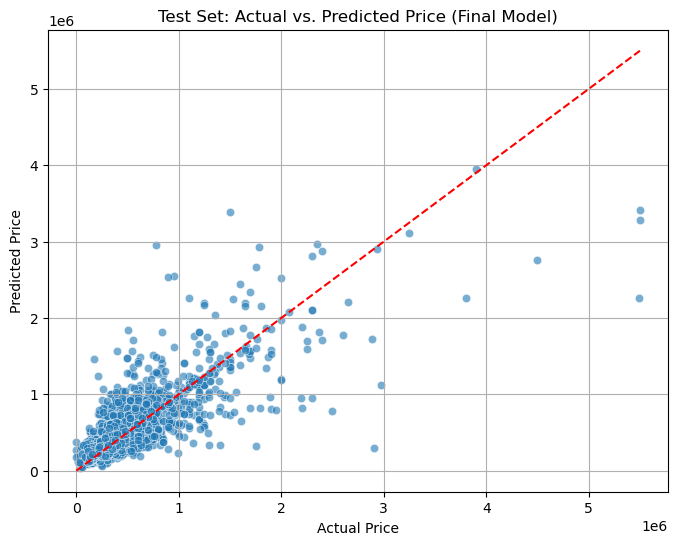

In [62]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_original, y=y_pred_final, alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Test Set: Actual vs. Predicted Price (Final Model)')
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'r--')
plt.grid(True)
plt.show()

#### as you can see from this graph, the predicted price finds the line of best fit and tries to guess the actual price.
#### Problem is, too many data points are scattered in a big cloud, which is hard to capture with mlp

# PART 2 (LAB 8 START)

In [2]:
numerical_features = ['bed', 'bath', 'acre_lot', 'house_size']

Q1 = data[numerical_features].quantile(0.25)
Q3 = data[numerical_features].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = data[~((data[numerical_features] < lower_bound) | (data[numerical_features] > upper_bound)).any(axis=1)]

print(f"Original dataset shape: {data.shape}")
print(f"Filtered dataset shape: {filtered_data.shape}")


Original dataset shape: (27553, 8)
Filtered dataset shape: (21876, 8)


#### After finishing my presentation for this dataset, I have learned how to deal with outliers using the interquantile range. Hence, I no longer need to rely on a scaled y

In [3]:
print(f"Count total NaN at each column in New York DataFrame: \n\n{filtered_data.isnull().sum()}")
print(filtered_data.dtypes)
print(filtered_data.sample(5))
filtered_data = filtered_data.drop(["brokered_by", "street"], axis=1)

Count total NaN at each column in New York DataFrame: 

brokered_by    0
price          0
bed            0
bath           0
acre_lot       0
street         0
city           0
house_size     0
dtype: int64
brokered_by    float64
price          float64
bed            float64
bath           float64
acre_lot       float64
street         float64
city            object
house_size     float64
dtype: object
       brokered_by     price  bed  bath  acre_lot     street           city  \
9675      102144.0  225000.0  2.0   2.0      0.21   100171.0        Mankato   
24697      31368.0  469900.0  4.0   3.0      0.42   875359.0      Rochester   
6358       83315.0  629900.0  4.0   3.0      0.50  1358384.0       Plymouth   
17751      71244.0  275000.0  2.0   2.0      0.05    95447.0  Brooklyn Park   
20859      22611.0  325000.0  5.0   2.0      0.26  1789375.0    Bloomington   

       house_size  
9675       1310.0  
24697      3336.0  
6358       3324.0  
17751      1613.0  
20859      2001.0  



Tuning for solver: lbfgs



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

Solver: lbfgs, Alpha: 0.0001, Activation: relu, Learning Rate: constant
Mean Train R²: 0.7906, Validation R²: 0.4919
Mean Train MAE: 48642.8009, Validation MAE: 73763.7611



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

Solver: lbfgs, Alpha: 0.0001, Activation: relu, Learning Rate: adaptive
Mean Train R²: 0.7906, Validation R²: 0.4919
Mean Train MAE: 48642.8009, Validation MAE: 73763.7611



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

Solver: lbfgs, Alpha: 0.0001, Activation: relu, Learning Rate: invscaling
Mean Train R²: 0.7906, Validation R²: 0.4919
Mean Train MAE: 48642.8009, Validation MAE: 73763.7611

Solver: lbfgs, Alpha: 0.0001, Activation: identity, Learning Rate: constant
Mean Train R²: 0.5882, Validation R²: 0.5404
Mean Train MAE: 69083.8728, Validation MAE: 75458.1143

Solver: lbfgs, Alpha: 0.0001, Activation: identity, Learning Rate: adaptive
Mean Train R²: 0.5882, Validation R²: 0.5404
Mean Train MAE: 69083.8728, Validation MAE: 75458.1143

Solver: lbfgs, Alpha: 0.0001, Activation: identity, Learning Rate: invscaling
Mean Train R²: 0.5882, Validation R²: 0.5404
Mean Train MAE: 69083.8728, Validation MAE: 75458.1143

Solver: lbfgs, Alpha: 0.0001, Activation: tanh, Learning Rate: constant
Mean Train R²: 0.0631, Validation R²: 0.2028
Mean Train MAE: 113859.1416, Validation MAE: 105075.5831

Solver: lbfgs, Alpha: 0.0001, Activation: tanh, Learning Rate: adaptive
Mean Train R²: 0.0631, Validation R²: 0.2028


c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

Solver: lbfgs, Alpha: 0.001, Activation: relu, Learning Rate: constant
Mean Train R²: 0.7873, Validation R²: 0.5217
Mean Train MAE: 48587.6097, Validation MAE: 70795.6742



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

Solver: lbfgs, Alpha: 0.001, Activation: relu, Learning Rate: adaptive
Mean Train R²: 0.7873, Validation R²: 0.5217
Mean Train MAE: 48587.6097, Validation MAE: 70795.6742



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

Solver: lbfgs, Alpha: 0.001, Activation: relu, Learning Rate: invscaling
Mean Train R²: 0.7873, Validation R²: 0.5217
Mean Train MAE: 48587.6097, Validation MAE: 70795.6742

Solver: lbfgs, Alpha: 0.001, Activation: identity, Learning Rate: constant
Mean Train R²: 0.5882, Validation R²: 0.5404
Mean Train MAE: 69083.8036, Validation MAE: 75457.3159

Solver: lbfgs, Alpha: 0.001, Activation: identity, Learning Rate: adaptive
Mean Train R²: 0.5882, Validation R²: 0.5404
Mean Train MAE: 69083.8036, Validation MAE: 75457.3159

Solver: lbfgs, Alpha: 0.001, Activation: identity, Learning Rate: invscaling
Mean Train R²: 0.5882, Validation R²: 0.5404
Mean Train MAE: 69083.8036, Validation MAE: 75457.3159

Solver: lbfgs, Alpha: 0.001, Activation: tanh, Learning Rate: constant
Mean Train R²: 0.0594, Validation R²: 0.1937
Mean Train MAE: 114057.8681, Validation MAE: 105411.0135

Solver: lbfgs, Alpha: 0.001, Activation: tanh, Learning Rate: adaptive
Mean Train R²: 0.0594, Validation R²: 0.1937
Mean T

c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Alpha: 0.001, Activation: logistic, Learning Rate: constant
Mean Train R²: 0.0052, Validation R²: -0.0000
Mean Train MAE: 118390.3442, Validation MAE: 120378.1685



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Alpha: 0.001, Activation: logistic, Learning Rate: adaptive
Mean Train R²: 0.0052, Validation R²: -0.0000
Mean Train MAE: 118390.3442, Validation MAE: 120378.1685



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Alpha: 0.001, Activation: logistic, Learning Rate: invscaling
Mean Train R²: 0.0052, Validation R²: -0.0000
Mean Train MAE: 118390.3442, Validation MAE: 120378.1685



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

Solver: lbfgs, Alpha: 0.01, Activation: relu, Learning Rate: constant
Mean Train R²: 0.7947, Validation R²: 0.5183
Mean Train MAE: 47991.9474, Validation MAE: 71707.6630



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

Solver: lbfgs, Alpha: 0.01, Activation: relu, Learning Rate: adaptive
Mean Train R²: 0.7947, Validation R²: 0.5183
Mean Train MAE: 47991.9474, Validation MAE: 71707.6630



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

Solver: lbfgs, Alpha: 0.01, Activation: relu, Learning Rate: invscaling
Mean Train R²: 0.7947, Validation R²: 0.5183
Mean Train MAE: 47991.9474, Validation MAE: 71707.6630

Solver: lbfgs, Alpha: 0.01, Activation: identity, Learning Rate: constant
Mean Train R²: 0.5882, Validation R²: 0.5404
Mean Train MAE: 69085.4403, Validation MAE: 75457.6687

Solver: lbfgs, Alpha: 0.01, Activation: identity, Learning Rate: adaptive
Mean Train R²: 0.5882, Validation R²: 0.5404
Mean Train MAE: 69085.4403, Validation MAE: 75457.6687

Solver: lbfgs, Alpha: 0.01, Activation: identity, Learning Rate: invscaling
Mean Train R²: 0.5882, Validation R²: 0.5404
Mean Train MAE: 69085.4403, Validation MAE: 75457.6687



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Alpha: 0.01, Activation: tanh, Learning Rate: constant
Mean Train R²: 0.0589, Validation R²: 0.1919
Mean Train MAE: 114097.8162, Validation MAE: 105689.4369



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Alpha: 0.01, Activation: tanh, Learning Rate: adaptive
Mean Train R²: 0.0589, Validation R²: 0.1919
Mean Train MAE: 114097.8162, Validation MAE: 105689.4369



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Alpha: 0.01, Activation: tanh, Learning Rate: invscaling
Mean Train R²: 0.0589, Validation R²: 0.1919
Mean Train MAE: 114097.8162, Validation MAE: 105689.4369

Solver: lbfgs, Alpha: 0.01, Activation: logistic, Learning Rate: constant
Mean Train R²: -0.0000, Validation R²: -0.0000
Mean Train MAE: 118960.0655, Validation MAE: 120378.1024

Solver: lbfgs, Alpha: 0.01, Activation: logistic, Learning Rate: adaptive
Mean Train R²: -0.0000, Validation R²: -0.0000
Mean Train MAE: 118960.0655, Validation MAE: 120378.1024

Solver: lbfgs, Alpha: 0.01, Activation: logistic, Learning Rate: invscaling
Mean Train R²: -0.0000, Validation R²: -0.0000
Mean Train MAE: 118960.0655, Validation MAE: 120378.1024



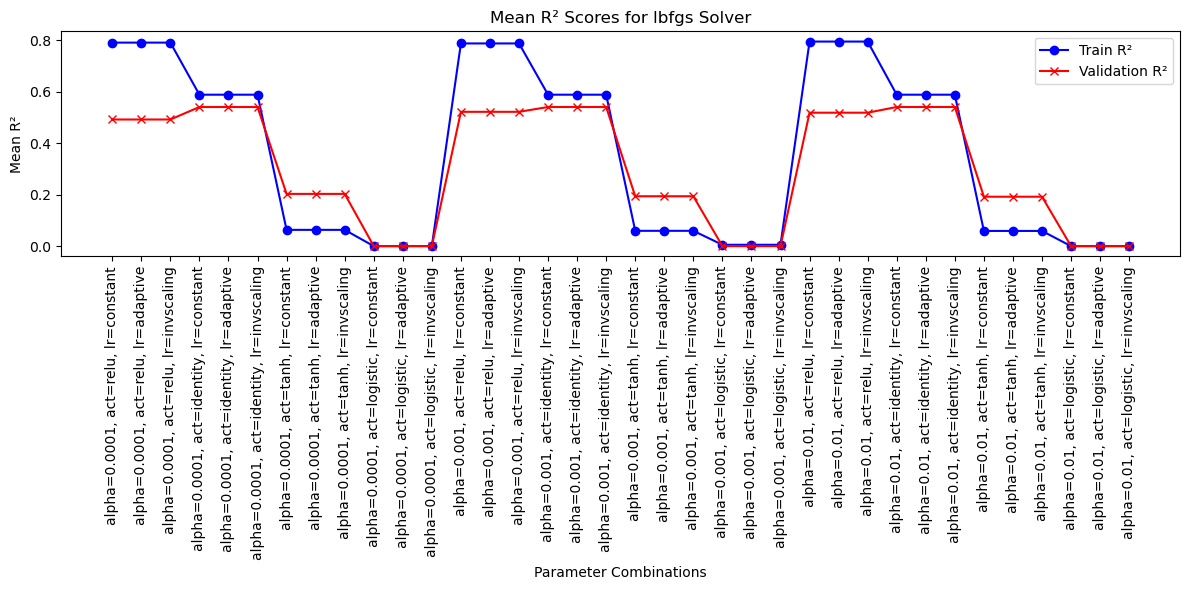

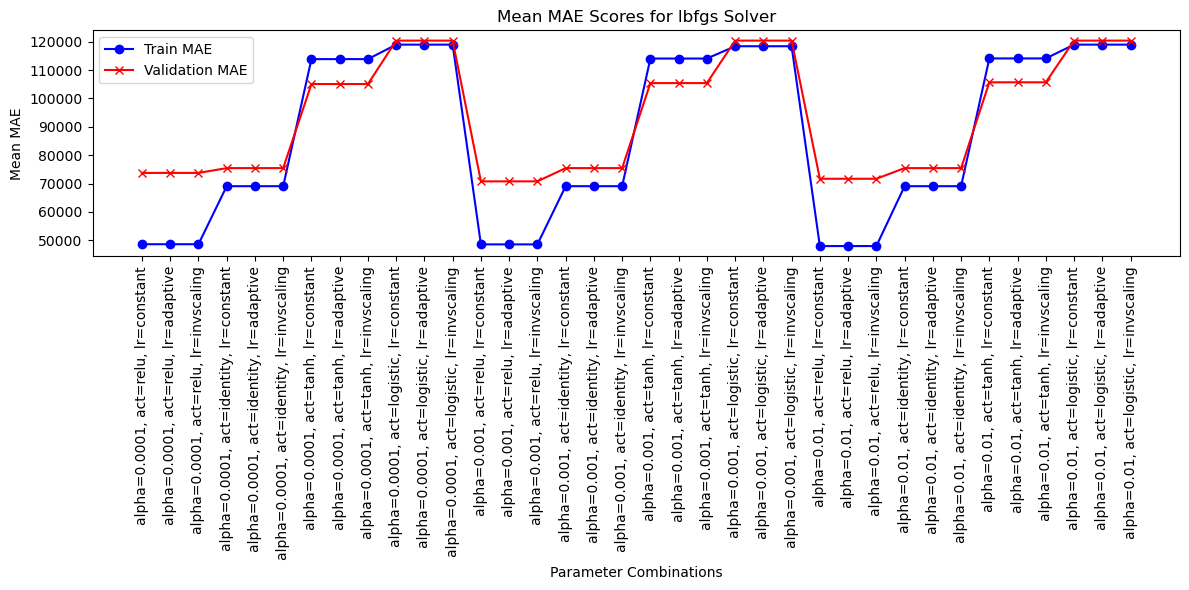

In [12]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_split, X_validation, y_train_split, y_validation = train_test_split(X_train, y_train, test_size=0.125, random_state=0)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bed', 'bath', 'acre_lot']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['city'])
    ])

param_grid = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'activation': ['relu', 'identity', 'tanh', 'logistic'],
    'learning_rate': ['constant', 'adaptive', 'invscaling']
}

kf = KFold(n_splits=3, shuffle=True, random_state=0)

def cross_validation_with_solver(solver_name, param_grid, X_train_split, y_train_split, X_validation, y_validation):
    train_r2_scores, val_r2_scores = [], []
    train_mae_scores, val_mae_scores = [], []
    param_combinations = []

    for alpha in param_grid['alpha']:
        for activation in param_grid['activation']:
            for learning_rate in param_grid['learning_rate']:
                train_r2_folds, train_mae_folds = [], []

                for train_index, val_index in kf.split(X_train_split):
                    X_train_cv, X_val_cv = X_train_split.iloc[train_index], X_train_split.iloc[val_index]
                    y_train_cv, y_val_cv = y_train_split.iloc[train_index], y_train_split.iloc[val_index]

                    pipeline = Pipeline([
                        ('preprocessor', preprocessor),
                        ('model', MLPRegressor(
                            solver=solver_name, alpha=alpha, activation=activation,
                            learning_rate=learning_rate, hidden_layer_sizes=(20, 20, 20),
                            max_iter=2000, early_stopping=True, n_iter_no_change=20, random_state=0
                        ))
                    ])

                    pipeline.fit(X_train_cv, y_train_cv)
                    y_train_pred = pipeline.predict(X_train_cv)

                    train_r2_folds.append(r2_score(y_train_cv, y_train_pred))
                    train_mae_folds.append(mean_absolute_error(y_train_cv, y_train_pred))

                mean_train_r2 = np.mean(train_r2_folds)
                mean_train_mae = np.mean(train_mae_folds)

                y_val_pred = pipeline.predict(X_validation)
                val_r2 = r2_score(y_validation, y_val_pred)
                val_mae = mean_absolute_error(y_validation, y_val_pred)

                train_r2_scores.append(mean_train_r2)
                val_r2_scores.append(val_r2)
                train_mae_scores.append(mean_train_mae)
                val_mae_scores.append(val_mae)
                param_combinations.append(f'alpha={alpha}, act={activation}, lr={learning_rate}')

                print(f"Solver: {solver_name}, Alpha: {alpha}, Activation: {activation}, Learning Rate: {learning_rate}")
                print(f"Train R²: {mean_train_r2:.4f}, Validation R²: {val_r2:.4f}")
                print(f"Train MAE: {mean_train_mae:.4f}, Validation MAE: {val_mae:.4f}\n")

    plt.figure(figsize=(12, 6))
    plt.plot(param_combinations, train_r2_scores, label='Train R²', color='blue', marker='o')
    plt.plot(param_combinations, val_r2_scores, label='Validation R²', color='red', marker='x')
    plt.xticks(rotation=90)
    plt.title(f'Mean R² Scores for {solver_name} Solver')
    plt.xlabel('Parameter Combinations')
    plt.ylabel('Mean R²')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(param_combinations, train_mae_scores, label='Train MAE', color='blue', marker='o')
    plt.plot(param_combinations, val_mae_scores, label='Validation MAE', color='red', marker='x')
    plt.xticks(rotation=90)
    plt.title(f'Mean MAE Scores for {solver_name} Solver')
    plt.xlabel('Parameter Combinations')
    plt.ylabel('Mean MAE')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return train_r2_scores, val_r2_scores, train_mae_scores, val_mae_scores

print("\nTuning for solver: lbfgs\n")
train_r2_lbfgs, val_r2_lbfgs, train_mae_lbfgs, val_mae_lbfgs = cross_validation_with_solver(
    'lbfgs', param_grid, X_train_split, y_train_split, X_validation, y_validation)



#### FOR LBFGS
#### As can be seen from the graphs, identity is the most reliable activation parameter where training and validation are close while r2 and mae scores are the highest. For some reason alpha parameter holds no sway over the model where high, medium or low alphas hold the same values 
#### Highest scores are:
#### Mean Validation R²: 0.5404
#### Mean Validation MAE: 75457.3159
#### With any alpha, identity activator and any learning rate. Though I would not mention learning rate much because for lbfgs learning rate does not matter

#### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### First, I initialized lbfgs solver, but as you can see once it stops and reaches the next solver, the problems start appearing
#### Hence I was forced to divide the code into different parts to figure out the mistake
#### Probably the main reason is that the dataset is too complex and requires extensive feature selection and data understanding, which was not required for lab 7 or 8


Tuning for solver: sgd

Solver: sgd, Alpha: 0.0001, Activation: tanh, Learning Rate: constant
Mean Train R²: -0.0007, Validation R²: -0.0015
Mean Train MAE: 118860.1861, Validation MAE: 119508.2935

Solver: sgd, Alpha: 0.0001, Activation: tanh, Learning Rate: adaptive
Mean Train R²: -0.0007, Validation R²: -0.0015
Mean Train MAE: 118860.1861, Validation MAE: 119508.2935

Solver: sgd, Alpha: 0.0001, Activation: tanh, Learning Rate: invscaling
Mean Train R²: -0.0012, Validation R²: -0.0022
Mean Train MAE: 118083.6309, Validation MAE: 119294.7966

Solver: sgd, Alpha: 0.0001, Activation: logistic, Learning Rate: constant
Mean Train R²: -0.0006, Validation R²: -0.0010
Mean Train MAE: 118870.8515, Validation MAE: 119684.1821

Solver: sgd, Alpha: 0.0001, Activation: logistic, Learning Rate: adaptive
Mean Train R²: -0.0006, Validation R²: -0.0010
Mean Train MAE: 118870.8515, Validation MAE: 119684.1821

Solver: sgd, Alpha: 0.0001, Activation: logistic, Learning Rate: invscaling
Mean Train R²:

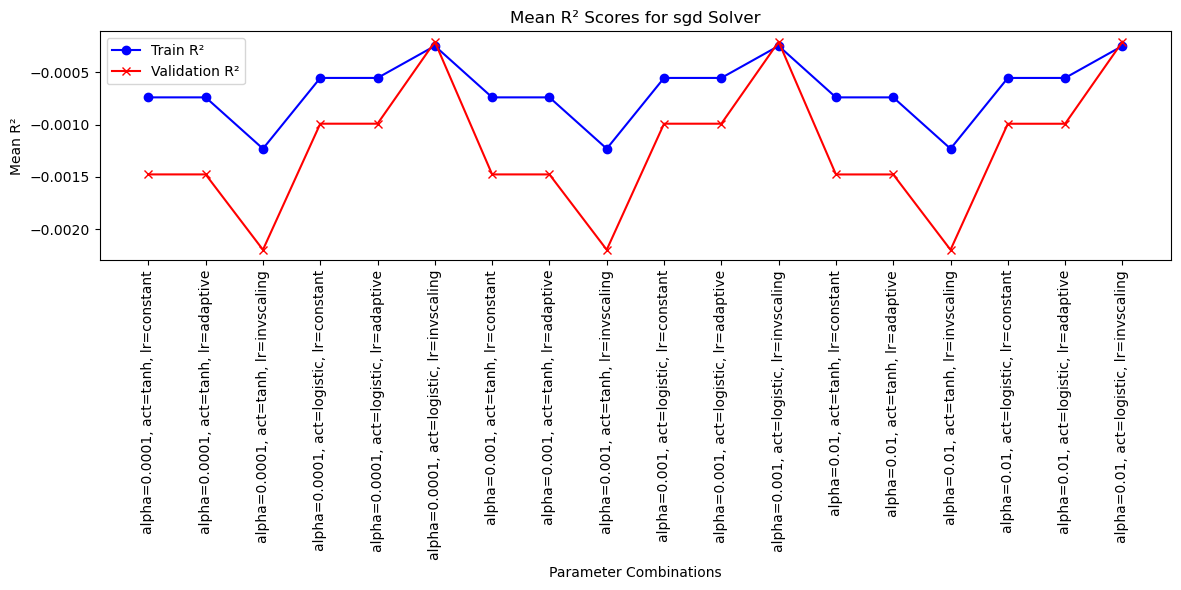

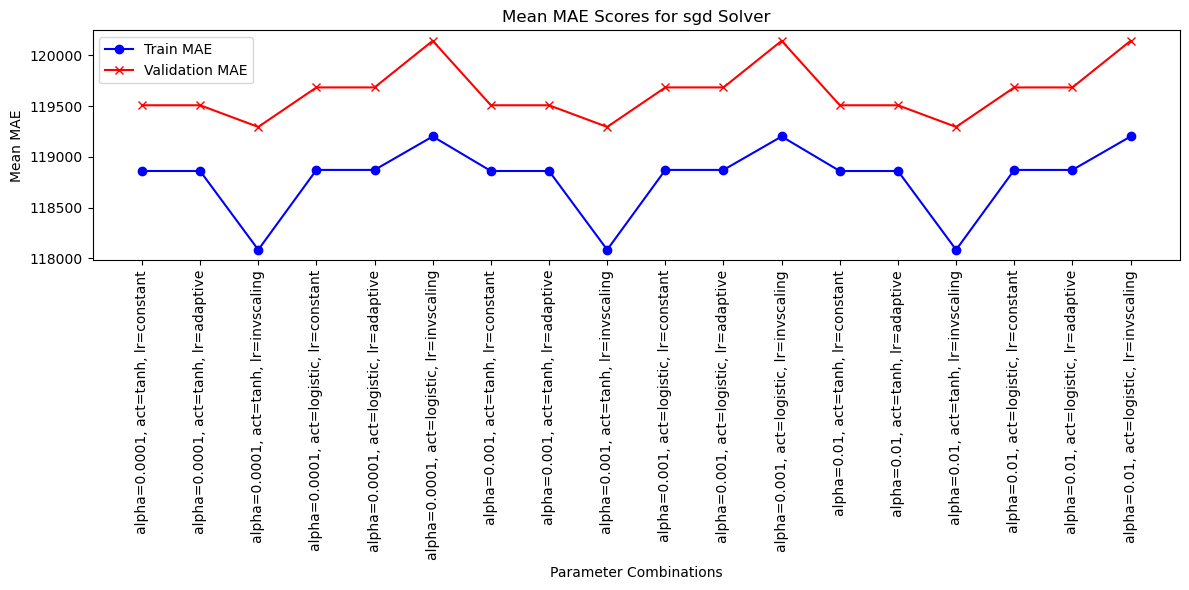

In [18]:
param_grid = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'activation': ['tanh','logistic'],
    'learning_rate': ['constant', 'adaptive', 'invscaling']
}
    
print("\nTuning for solver: sgd\n")
train_r2_sgd, val_r2_sgd, train_mae_sgd, val_mae_sgd = cross_validation_with_solver(
    'sgd', param_grid, X_train_split, y_train_split, X_validation, y_validation)

#### FOR SGD
#### As can be seen from the graph, it does not matter what parameters are used, since we can only test on two activators (tanh and logistic), we get r2 and mae scores that are lower than baseline


Tuning for solver: adam

Solver: adam, Alpha: 0.0001, Activation: tanh, Learning Rate: constant
Mean Train R²: -3.9071, Validation R²: -3.8871
Mean Train MAE: 338569.7609, Validation MAE: 339266.0891

Solver: adam, Alpha: 0.0001, Activation: tanh, Learning Rate: adaptive
Mean Train R²: -3.9071, Validation R²: -3.8871
Mean Train MAE: 338569.7609, Validation MAE: 339266.0891

Solver: adam, Alpha: 0.0001, Activation: tanh, Learning Rate: invscaling
Mean Train R²: -3.9071, Validation R²: -3.8871
Mean Train MAE: 338569.7609, Validation MAE: 339266.0891

Solver: adam, Alpha: 0.0001, Activation: logistic, Learning Rate: constant
Mean Train R²: -3.9073, Validation R²: -3.8874
Mean Train MAE: 338577.6600, Validation MAE: 339277.5010

Solver: adam, Alpha: 0.0001, Activation: logistic, Learning Rate: adaptive
Mean Train R²: -3.9073, Validation R²: -3.8874
Mean Train MAE: 338577.6600, Validation MAE: 339277.5010

Solver: adam, Alpha: 0.0001, Activation: logistic, Learning Rate: invscaling
Mean Tr

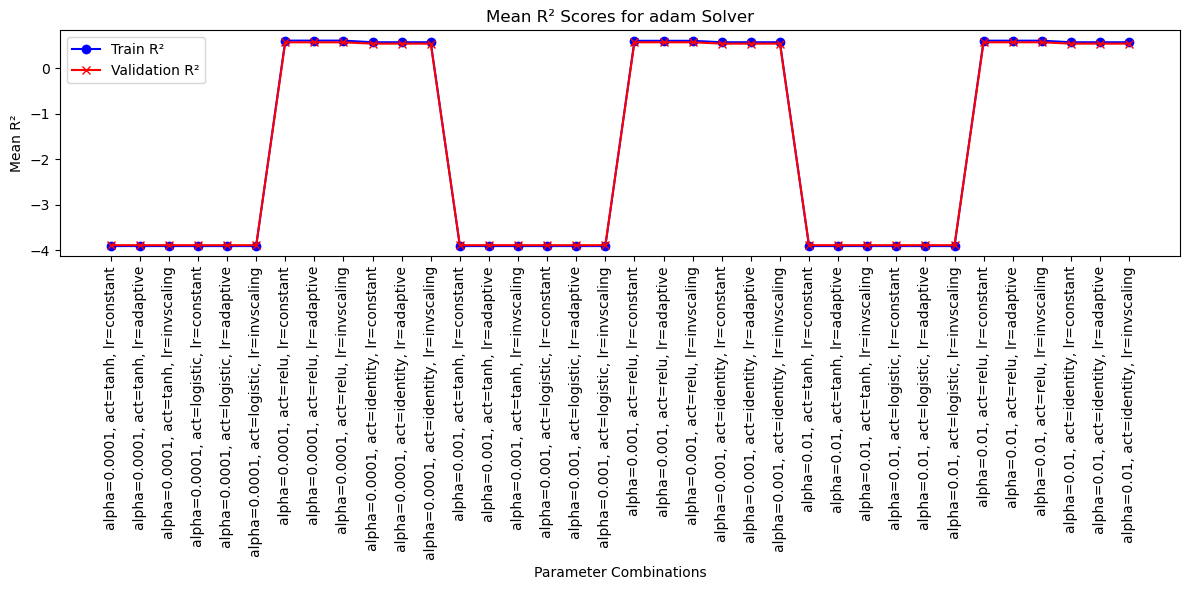

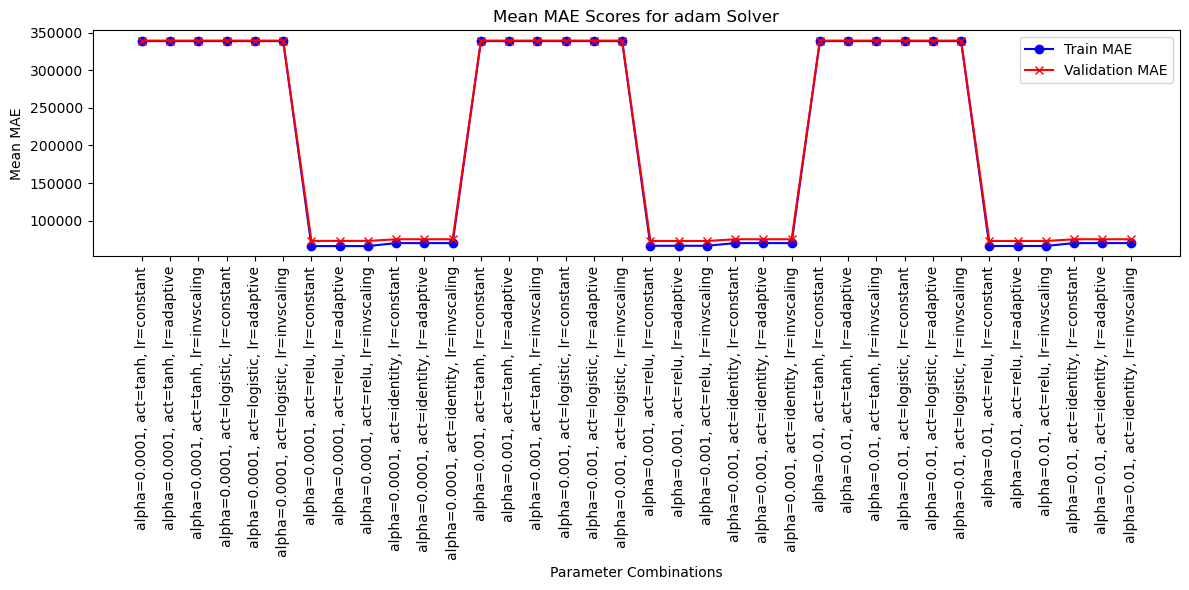

In [19]:
param_grid = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'activation': ['tanh','logistic', 'relu', 'identity' ],
    'learning_rate': ['constant', 'adaptive', 'invscaling']
}

print("\nTuning for solver: adam\n")
train_r2_adam, val_r2_adam, train_mae_adam, val_mae_adam = cross_validation_with_solver(
    'adam', param_grid, X_train_split, y_train_split, X_validation, y_validation)

#### Adam is the most fitting solver for our dataset with the highest scores for r2 and lowest for mae. We can observe that best activation parameter is relu and alpha score of 0.001. 
#### Highest scores are:
#### Mean Validation R²: 0.5688
#### Mean Validation MAE: 73003.5041
#### The reason why the scores don't look like they depend on learning rate is because the default learning rate is very small. At that learning rate, the differences are hard to notice. Not to mention the convergence of the dataset might not hold due to limited amount of iterations. Despite that, the data is enough to conclude that MLPRegressor is indeed one of the most versatile estimators due to the fact that you can almost always improve the score by tweaking various parameters.
#### As a result, I can say that MLP estimator is indeed versatile, however it is also one of the most tedious and time consuming estimators to train among all others.

#### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### CURRENT RESULT (LAB 8)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_split, X_validation, y_train_split, y_validation = train_test_split(X_train, y_train, test_size=0.125, random_state=0)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bed', 'bath', 'acre_lot']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['city'])
    ])

param_grid_adam = {
    'alpha': [0.0001, 0.001, 0.01],
    'activation': ['relu', 'identity'],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'learning_rate_init': [0.1, 0.01, 0.0001]
}

kf = KFold(n_splits=3, shuffle=True, random_state=0)

def cross_validation_adam(param_grid, X_train_split, y_train_split, X_validation, y_validation):
    train_r2_scores, val_r2_scores = [], []
    train_mae_scores, val_mae_scores = [], []
    param_combinations = []

    for alpha in param_grid['alpha']:
        for activation in param_grid['activation']:
            for learning_rate in param_grid['learning_rate']:
                for learning_rate_init in param_grid['learning_rate_init']:
                    
                    train_r2_folds, train_mae_folds = [], []

                    for train_index, val_index in kf.split(X_train_split):
                        X_train_cv, X_val_cv = X_train_split.iloc[train_index], X_train_split.iloc[val_index]
                        y_train_cv, y_val_cv = y_train_split.iloc[train_index], y_train_split.iloc[val_index]

                        pipeline = Pipeline([
                            ('preprocessor', preprocessor),
                            ('model', MLPRegressor(
                                solver='adam',
                                alpha=alpha,
                                activation=activation,
                                learning_rate=learning_rate,
                                learning_rate_init=learning_rate_init,
                                hidden_layer_sizes=(20, 20, 20),
                                max_iter=2000,
                                random_state=0
                            ))
                        ])

                        pipeline.fit(X_train_cv, y_train_cv)
                        y_train_pred = pipeline.predict(X_train_cv)

                        train_r2_folds.append(r2_score(y_train_cv, y_train_pred))
                        train_mae_folds.append(mean_absolute_error(y_train_cv, y_train_pred))

                    mean_train_r2 = np.mean(train_r2_folds)
                    mean_train_mae = np.mean(train_mae_folds)

                    y_val_pred = pipeline.predict(X_validation)
                    val_r2 = r2_score(y_validation, y_val_pred)
                    val_mae = mean_absolute_error(y_validation, y_val_pred)

                    train_r2_scores.append(mean_train_r2)
                    val_r2_scores.append(val_r2)
                    train_mae_scores.append(mean_train_mae)
                    val_mae_scores.append(val_mae)

                    param_combinations.append(f'alpha={alpha}, act={activation}, lr={learning_rate}, lr_init={learning_rate_init}')

                    print(f"Alpha: {alpha}, Activation: {activation}, Learning Rate: {learning_rate}, Learning Rate Init: {learning_rate_init}")
                    print(f"Train R²: {mean_train_r2:.4f}, Validation R²: {val_r2:.4f}")
                    print(f"Train MAE: {mean_train_mae:.4f}, Validation MAE: {val_mae:.4f}\n")

    plt.figure(figsize=(12, 6))
    plt.plot(param_combinations, train_r2_scores, label='Train R²', color='blue', marker='o')
    plt.plot(param_combinations, val_r2_scores, label='Validation R²', color='red', marker='x')
    plt.xticks(rotation=90)
    plt.title(f'Mean R² Scores for Adam Solver')
    plt.xlabel('Parameter Combinations')
    plt.ylabel('Mean R²')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(param_combinations, train_mae_scores, label='Train MAE', color='blue', marker='o')
    plt.plot(param_combinations, val_mae_scores, label='Validation MAE', color='red', marker='x')
    plt.xticks(rotation=90)
    plt.title(f'Mean MAE Scores for Adam Solver')
    plt.xlabel('Parameter Combinations')
    plt.ylabel('Mean MAE')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return train_r2_scores, val_r2_scores, train_mae_scores, val_mae_scores

print("\nTuning for solver: adam\n")
train_r2_adam, val_r2_adam, train_mae_adam, val_mae_adam = cross_validation_adam(
    param_grid_adam, X_train_split, y_train_split, X_validation, y_validation)



Tuning for solver: adam

Alpha: 0.0001, Activation: relu, Learning Rate: constant, Learning Rate Init: 0.1
Train R²: 0.7505, Validation R²: 0.5166
Train MAE: 83861.0748, Validation MAE: 103635.6412

Alpha: 0.0001, Activation: relu, Learning Rate: constant, Learning Rate Init: 0.01
Train R²: 0.7455, Validation R²: -1.9395
Train MAE: 82906.6236, Validation MAE: 116153.9284



c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_split, X_validation, y_train_split, y_validation = train_test_split(X_train, y_train, test_size=0.125, random_state=0)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bed', 'bath', 'acre_lot']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['city'])
    ])

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MLPRegressor(
        hidden_layer_sizes=(20, 20, 20),
        max_iter=2000,
        random_state=0,
        solver='adam',
        activation='relu',
        learning_rate='invscaling',
        alpha = 0.0001,
        learning_rate_init = 0.1
        
    ))
])

final_pipeline.fit(X_train, y_train)

y_pred_final = final_pipeline.predict(X_test)

test_r2_final = r2_score(y_test, y_pred_final)
test_mse_final = mean_squared_error(y_test, y_pred_final)
test_mae_final = mean_absolute_error(y_test, y_pred_final)
print(f"\nFinal R2: {test_r2_final:.4f}")
print(f"MSE: {test_mse_final:.4f}")
print(f"MAE: {test_mae_final:.4f}")


Final R2: 0.5652
MSE: 41915661292.3209
MAE: 97239.3579


#### Since the computations take too long, I spent two days learning the methods and changing cross validation and the result still has not improved
#### Now I am faced with the deadline, so I cannot provide a better score than the lab 7 score

#### PREVIOUS RESULT (LAB 7)

In [22]:
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MLPRegressor(
        hidden_layer_sizes=(20, 20, 20),
        max_iter=2000,
        random_state=0,
    ))
])

final_pipeline.fit(X_train, y_train)

y_pred_final = final_pipeline.predict(X_test)

test_r2_final = r2_score(y_test, y_pred_final)
test_mse_final = mean_squared_error(y_test, y_pred_final)
test_mae_final = mean_absolute_error(y_test, y_pred_final)
print(f"\nFinal R2: {test_r2_final:.4f}")
print(f"MSE: {test_mse_final:.4f}")
print(f"MAE: {test_mae_final:.4f}")


Final R2: 0.5826
MSE: 11802348424.3779
MAE: 68830.0663


c:\Users\DhM\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


#### These results show us that using scaled target value as a predictor nets a much more valuable prediction in terms of capturing the overall shapes the data takes. However, in terms of prediction accuracy, using scaled y (I used scaled y in lab 7) is much worse
# R2 from lab 8 is 0.5826 compared to 0.5545 with additional parameters (if I compile without learning rate = 0.0001, the result is more than 0.57)
# Which is less by 5 percent